# Generative Adversarial Networks (GANs)

So far in CS231N, all the applications of neural networks that we have explored have been **discriminative models** that take an input and are trained to produce a labeled output. This has ranged from straightforward classification of image categories to sentence generation (which was still phrased as a classification problem, our labels were in vocabulary space and we’d learned a recurrence to capture multi-word labels). In this notebook, we will expand our repetoire, and build **generative models** using neural networks. Specifically, we will learn how to build models which generate novel images that resemble a set of training images.

### What is a GAN?

In 2014, [Goodfellow et al.](https://arxiv.org/abs/1406.2661) presented a method for training generative models called Generative Adversarial Networks (GANs for short). In a GAN, we build two different neural networks. Our first network is a traditional classification network, called the **discriminator**. We will train the discriminator to take images, and classify them as being real (belonging to the training set) or fake (not present in the training set). Our other network, called the **generator**, will take random noise as input and transform it using a neural network to produce images. The goal of the generator is to fool the discriminator into thinking the images it produced are real.

We can think of this back and forth process of the generator ($G$) trying to fool the discriminator ($D$), and the discriminator trying to correctly classify real vs. fake as a minimax game:
$$\underset{G}{\text{minimize}}\; \underset{D}{\text{maximize}}\; \mathbb{E}_{x \sim p_\text{data}}\left[\log D(x)\right] + \mathbb{E}_{z \sim p(z)}\left[\log \left(1-D(G(z))\right)\right]$$
where $x \sim p_\text{data}$ are samples from the input data, $z \sim p(z)$ are the random noise samples, $G(z)$ are the generated images using the neural network generator $G$, and $D$ is the output of the discriminator, specifying the probability of an input being real. In [Goodfellow et al.](https://arxiv.org/abs/1406.2661), they analyze this minimax game and show how it relates to minimizing the Jensen-Shannon divergence between the training data distribution and the generated samples from $G$.

To optimize this minimax game, we will aternate between taking gradient *descent* steps on the objective for $G$, and gradient *ascent* steps on the objective for $D$:
1. update the **generator** ($G$) to minimize the probability of the __discriminator making the correct choice__. 
2. update the **discriminator** ($D$) to maximize the probability of the __discriminator making the correct choice__.

While these updates are useful for analysis, they do not perform well in practice. Instead, we will use a different objective when we update the generator: maximize the probability of the **discriminator making the incorrect choice**. This small change helps to allevaiate problems with the generator gradient vanishing when the discriminator is confident. This is the standard update used in most GAN papers, and was used in the original paper from [Goodfellow et al.](https://arxiv.org/abs/1406.2661). 

In this assignment, we will alternate the following updates:
1. Update the generator ($G$) to maximize the probability of the discriminator making the incorrect choice on generated data:
$$\underset{G}{\text{maximize}}\;  \mathbb{E}_{z \sim p(z)}\left[\log D(G(z))\right]$$
2. Update the discriminator ($D$), to maximize the probability of the discriminator making the correct choice on real and generated data:
$$\underset{D}{\text{maximize}}\; \mathbb{E}_{x \sim p_\text{data}}\left[\log D(x)\right] + \mathbb{E}_{z \sim p(z)}\left[\log \left(1-D(G(z))\right)\right]$$

### What else is there?
Since 2014, GANs have exploded into a huge research area, with massive [workshops](https://sites.google.com/site/nips2016adversarial/), and [hundreds of new papers](https://github.com/hindupuravinash/the-gan-zoo). Compared to other approaches for generative models, they often produce the highest quality samples but are some of the most difficult and finicky models to train (see [this github repo](https://github.com/soumith/ganhacks) that contains a set of 17 hacks that are useful for getting models working). Improving the stabiilty and robustness of GAN training is an open research question, with new papers coming out every day! For a more recent tutorial on GANs, see [here](https://arxiv.org/abs/1701.00160). There is also some even more recent exciting work that changes the objective function to Wasserstein distance and yields much more stable results across model architectures: [WGAN](https://arxiv.org/abs/1701.07875), [WGAN-GP](https://arxiv.org/abs/1704.00028).


GANs are not the only way to train a generative model! For other approaches to generative modeling check out the [deep generative model chapter](http://www.deeplearningbook.org/contents/generative_models.html) of the Deep Learning [book](http://www.deeplearningbook.org). Another popular way of training neural networks as generative models is Variational Autoencoders (co-discovered [here](https://arxiv.org/abs/1312.6114) and [here](https://arxiv.org/abs/1401.4082)). Variational autoencoders combine neural networks with variational inference to train deep generative models. These models tend to be far more stable and easier to train but currently don't produce samples that are as pretty as GANs.

Example pictures of what you should expect (yours might look slightly different):

![caption](gan_outputs_tf.png)


## Setup

In [1]:
from __future__ import print_function, division
import tensorflow as tf
import numpy as np
import tensorflow.contrib.layers as ly

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# A bunch of utility functions

def show_images(images):
    images = np.reshape(images, [images.shape[0], -1])  # images reshape to (batch_size, D)
    sqrtn = int(np.ceil(np.sqrt(images.shape[0])))
    sqrtimg = int(np.ceil(np.sqrt(images.shape[1])))

    fig = plt.figure(figsize=(sqrtn, sqrtn))
    gs = gridspec.GridSpec(sqrtn, sqrtn)
    gs.update(wspace=0.05, hspace=0.05)

    for i, img in enumerate(images):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(img.reshape([sqrtimg,sqrtimg]))
    return

def preprocess_img(x):
    return 2 * x - 1.0

def deprocess_img(x):
    return (x + 1.0) / 2.0

def rel_error(x,y):
    return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

def count_params():
    """Count the number of parameters in the current TensorFlow graph """
    param_count = np.sum([np.prod(x.get_shape().as_list()) for x in tf.global_variables()])
    return param_count


def get_session():
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    session = tf.Session(config=config)
    return session

answers = np.load('gan-checks-tf.npz')


## Dataset

Extracting ./cs231n/datasets/MNIST_data\train-images-idx3-ubyte.gz
Extracting ./cs231n/datasets/MNIST_data\train-labels-idx1-ubyte.gz
Extracting ./cs231n/datasets/MNIST_data\t10k-images-idx3-ubyte.gz
Extracting ./cs231n/datasets/MNIST_data\t10k-labels-idx1-ubyte.gz


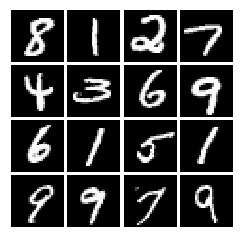

In [2]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('./cs231n/datasets/MNIST_data', one_hot=False)

# show a batch
show_images(mnist.train.next_batch(16)[0])

In [11]:
def sample_noise(batch_size, dim):
    """Generate random normal noise
    
    Inputs:
    - batch_size: integer giving the batch size of noise to generate
    - dim: integer giving the dimension of the the noise to generate
    
    Returns:
    TensorFlow Tensor containing uniform noise in [-1, 1] with shape [batch_size, dim]
    """
    # TODO: sample and return noise
    return tf.random_normal(shape=[batch_size, dim],
                            mean=0,
                            stddev=1) 

In [12]:
def leaky_relu(x, alpha=.1):
    """Compute the leaky ReLU activation function.
    
    Inputs:
    - x: TensorFlow Tensor with arbitrary shape
    - alpha: leak parameter for leaky ReLU
    
    Returns:
    TensorFlow Tensor with the same shape as x
    """
    # TODO: implement leaky ReLU    
    
    return tf.maximum(x,0) + tf.minimum(x,0) * alpha

## Discriminator

In [13]:
def discriminator(x):
    '''
    Input : x : [batch_size, 784]
    Output : logits : [batch_size , 1]
    '''
    x = tf.reshape(x, [-1,28,28,1])
    
    with tf.variable_scope('discriminator'):
        
        conv_1 = ly.conv2d(inputs=x, # 28 * 28 * 8 
                           num_outputs=8,
                           kernel_size=1,
                           stride=1,
                           padding='SAME',
                           activation_fn = leaky_relu,
                           normalizer_fn = ly.batch_norm,
                           scope='conv_1')
                           #weights_initializer = tf.random_normal_initializer(0,0.02))
        conv_2 = ly.conv2d(inputs=conv_1, # 14 * 14 * 16 
                           num_outputs=16,
                           kernel_size=3,
                           stride=2,
                           padding='SAME',
                           activation_fn = leaky_relu,
                           normalizer_fn = ly.batch_norm,
                           scope='conv_2')
                           #weights_initializer = tf.random_normal_initializer(0,0.02))
        conv_3 = ly.conv2d(inputs=conv_2, # 7 * 7 * 128
                           num_outputs=32,
                           kernel_size=3,
                           stride=2,
                           padding='SAME',
                           activation_fn = leaky_relu,
                           normalizer_fn = ly.batch_norm,
                           scope='conv_3')
                           #weights_initializer = tf.random_normal_initializer(0,0.02))
        conv_4 = ly.conv2d(inputs=conv_3, # 4 * 4 * 64 
                           num_outputs=64,
                           kernel_size=3,
                           stride=2,
                           padding='SAME',
                           activation_fn = leaky_relu,
                           normalizer_fn = ly.batch_norm,
                           scope='conv_4')
                           #weights_initializer = tf.random_normal_initializer(0,0.02))
        conv_4 = tf.reshape(conv_4, [-1,4*4*64])
        logits = ly.fully_connected(inputs=conv_4, 
                                    num_outputs=1,
                                    weights_initializer = tf.random_uniform_initializer(0,.02),
                                    scope='logits')        
        #print(logits.shape)
        return logits

In [14]:
# tf.reset_default_graph()
# x = tf.random_normal(shape=[10,784])
# with tf.Session() as sess:
#     a = discriminator(x)
#     sess.run(tf.global_variables_initializer())
#     sess.run(a)

## Generator : DConv

In [21]:
def generator(z):
    """Generate images from a random noise vector.
    
    Inputs:
    - z: TensorFlow Tensor of random noise with shape [batch_size, noise_dim]
    
    Returns:
    TensorFlow Tensor of generated images, with shape [batch_size, 784].
    """
    with tf.variable_scope("generator"):

        fc = ly.fully_connected(inputs=z, 
                                num_outputs=3 * 3 * 64,
                                activation_fn = leaky_relu,
                                normalizer_fn = ly.batch_norm,
                                weights_initializer = tf.random_uniform_initializer(0,.02),
                                scope='fc')
        fc_reshape = tf.reshape(fc, shape=[-1,3,3,64]) # 3 * 3 * 64
        dconv_1 = ly.conv2d_transpose(inputs=fc_reshape, # 7 * 7 * 32
                                      num_outputs=32,
                                      kernel_size=3,
                                      stride=2,
                                      padding='VALID',
                                      activation_fn=leaky_relu,
                                      normalizer_fn=ly.batch_norm,
                                      weights_initializer= tf.random_normal_initializer(0,.02),
                                      scope='dconv_1') 
        dconv_2 = ly.conv2d_transpose(inputs=dconv_1, # 14 * 14 * 16
                                      num_outputs=16,
                                      kernel_size=3,
                                      stride=2,
                                      padding='SAME',
                                      activation_fn=leaky_relu,
                                      normalizer_fn=ly.batch_norm,
                                      weights_initializer= tf.random_normal_initializer(0,.02),
                                      scope='dconv_2')
        dconv_3 = ly.conv2d_transpose(inputs=dconv_2, # 28 * 28 * 8
                                      num_outputs=8,
                                      kernel_size=3,
                                      stride=2,
                                      padding='SAME',
                                      activation_fn=leaky_relu,
                                      normalizer_fn=ly.batch_norm,
                                      weights_initializer= tf.random_normal_initializer(0,.02),
                                      scope='dconv_3')
        img = ly.conv2d_transpose(inputs=dconv_3, # 28 * 28 * 1
                                  num_outputs=1,
                                  kernel_size=3,
                                  stride=1,
                                  padding='SAME',
                                  weights_initializer= tf.random_normal_initializer(0,.02),
                                  scope='img')                                 
        img = tf.reshape(img,[-1,784]) # 784
        #print(img.shape)
        return img

In [16]:
# tf.reset_default_graph()
# with tf.Session() as sess:
#     z = tf.random_normal([10,200])
#     a = generator(z)
#     sess.run(tf.global_variables_initializer())
#     sess.run(a)

## WGANs Loss

In [17]:
def wgangp_loss(logits_real, logits_fake):
    """Compute the WGAN-GP loss.
    
    Inputs:
    - logits_real: Tensor, shape [batch_size, 1], output of discriminator
    - logits_fake: Tensor, shape[batch_size, 1], output of discriminator
    - batch_size: The number of examples in this batch
    - x: the input (real) images for this batch
    - G_sample: the generated (fake) images for this batch
    
    Returns:
    - D_loss: discriminator loss scalar
    - G_loss: generator loss scalar
    """
    # TODO: compute D_loss and G_loss
    D_loss =  - tf.reduce_mean(logits_real - logits_fake)
    
    G_loss =  - tf.reduce_mean(logits_fake)

    return D_loss, G_loss

## Adam Optimizer

In [18]:
def get_solvers(learning_rate=5e-5, beta1=.5, beta2=.9):
    """Create solvers for WGAN training.
    
    Inputs:
    - learning_rate: learning rate to use for both solvers
    - beta1: beta1 parameter for both solvers (first moment decay)
    
    Returns:
    - D_solver: instance of tf.train.AdamOptimizer with correct learning_rate and beta1
    - G_solver: instance of tf.train.AdamOptimizer with correct learning_rate and beta1
    """
    D_solver = tf.train.AdamOptimizer(learning_rate = learning_rate,
                                      beta1=beta1, beta2=beta2)
                                         
    
    G_solver = tf.train.AdamOptimizer(learning_rate = learning_rate,
                                      beta1=beta1, beta2=beta2)
    return D_solver, G_solver

## Hyperparameters

In [23]:
# learning rate of two networks
learning_rate_gen = 5e-5
learning_rate_dis = 5e-5

# steps of dis per global step
citers = 5

# batch_size
batch_size = 64

# noise_dim
z_dim = 64

# leaky relu paramter
alpha = .1

# maxiter = train_samples * epoch / batch_size
epoch = 50
print_every = 100
show_every = 500

# Adam optimizer 
beta1 = .5
beta2 = .9

# restriction on weights of discriminator network
clamp_lower = -.01
clamp_upper = .01

## Build the Graph

In [24]:
tf.reset_default_graph()

# placeholders for images from the training dataset
x = tf.placeholder(tf.float32, [None, 784])
z = sample_noise(batch_size=batch_size, dim=z_dim)
# generated images
G_sample = generator(z)

with tf.variable_scope("") as scope:
    #scale images to be -1 to 1
    logits_real = discriminator(preprocess_img(x))
    # Re-use discriminator weights on new inputs, share parameters
    scope.reuse_variables()
    logits_fake = discriminator(G_sample)

# Get the list of variables for the discriminator and generator
D_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES,'discriminator')
D_clip = [v.assign(tf.clip_by_value(v, clamp_lower, clamp_upper)) for v in D_vars]

G_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES,'generator')

D_solver, G_solver = get_solvers()

D_loss, G_loss = wgangp_loss(logits_real, logits_fake)
D_train_step = D_solver.minimize(D_loss, var_list=D_vars)
G_train_step = G_solver.minimize(G_loss, var_list=G_vars)

with tf.control_dependencies([D_train_step]):
    D_train_step = tf.tuple(D_clip)

In [25]:
# a giant helper function
def run_a_gan(sess, G_train_step, G_loss, D_train_step, D_loss,\
              show_every=show_every, print_every=print_every,\
              Citers = citers, batch_size=batch_size, num_epoch=epoch):
    """Train a GAN for a certain number of epochs.
    
    Inputs:
    - sess: A tf.Session that we want to use to run our data
    - Citers : discriminator steps per global step
    - G_train_step: A training step for the Generator
    - G_loss: Generator loss
    - D_train_step: A training step for the Generator
    - D_loss: Discriminator loss
    Returns:
        Nothing
    """
    # compute the number of iterations we need
    max_iter = int(mnist.train.num_examples*num_epoch/batch_size)
    for it in range(max_iter):
        ## every show often, show a sample result
        if it % show_every == 0:
            samples = sess.run(G_sample)
            fig = show_images(samples[:16])
            plt.show()
            print()
        ## setting citers per global step    
        if it < 50 or it % 500 == 0:
            citers = 50
        else:
            citers = Citers
            
        for ci in range(citers):
            # update discriminators citers times
            minibatch, _ = mnist.train.next_batch(batch_size)
            if ci != citers - 1:
                sess.run(D_train_step, feed_dict={x:minibatch})
            elif ci == citers - 1: 
                _, D_loss_curr = sess.run([D_train_step, D_loss], feed_dict={x:minibatch})
                    
        # update generator every global step    
        _, G_loss_curr = sess.run([G_train_step, G_loss], feed_dict={x: minibatch})

        # print loss every so often.
        # We want to make sure D_loss doesn't go to 0
        if it % print_every == 0:
            print('Iter: {}, D: {:.4}, G:{:.4}'.format(it,D_loss_curr,G_loss_curr))
    print('Final images')
    samples = sess.run(G_sample)

    fig = show_images(samples[:16])
    plt.show()

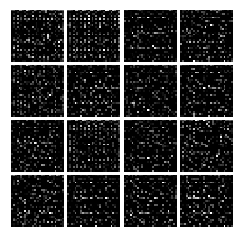


Iter: 0, D: -2.864, G:-0.1772
Iter: 100, D: -5.446, G:-0.002185
Iter: 200, D: -5.379, G:-0.0
Iter: 300, D: -5.305, G:-0.04776
Iter: 400, D: -5.209, G:-0.0005503


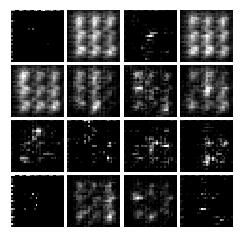


Iter: 500, D: -4.923, G:-0.0
Iter: 600, D: -5.05, G:-0.002461
Iter: 700, D: -4.324, G:-0.0896
Iter: 800, D: -4.619, G:-0.09564
Iter: 900, D: -4.945, G:-0.03669


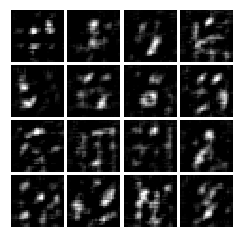


Iter: 1000, D: -5.075, G:-0.01456
Iter: 1100, D: -5.082, G:-0.08851
Iter: 1200, D: -5.063, G:-0.003218
Iter: 1300, D: -5.083, G:-0.02604
Iter: 1400, D: -5.08, G:-0.02781


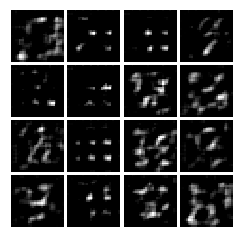


Iter: 1500, D: -5.051, G:-0.00463
Iter: 1600, D: -5.048, G:-0.02513
Iter: 1700, D: -4.978, G:-0.02537
Iter: 1800, D: -5.022, G:-0.05859
Iter: 1900, D: -4.974, G:-0.01846


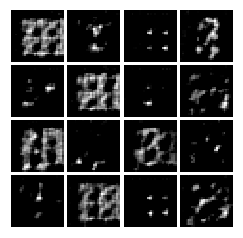


Iter: 2000, D: -4.939, G:-0.03664
Iter: 2100, D: -4.912, G:-0.04543
Iter: 2200, D: -4.82, G:-0.0141
Iter: 2300, D: -4.76, G:-0.08774
Iter: 2400, D: -4.674, G:-0.04079


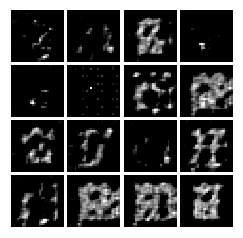


Iter: 2500, D: -4.611, G:-0.1512
Iter: 2600, D: -4.501, G:-0.08213
Iter: 2700, D: -4.517, G:-0.09606
Iter: 2800, D: -4.452, G:-0.06516
Iter: 2900, D: -4.33, G:-0.1976


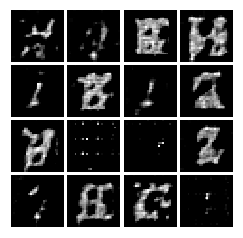


Iter: 3000, D: -4.245, G:-0.2534
Iter: 3100, D: -4.427, G:-0.4082
Iter: 3200, D: -4.259, G:-0.284
Iter: 3300, D: -4.261, G:-0.3478
Iter: 3400, D: -3.693, G:-0.293


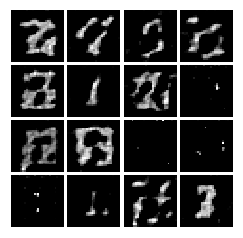


Iter: 3500, D: -4.047, G:-0.2697
Iter: 3600, D: -3.826, G:-0.1389
Iter: 3700, D: -3.791, G:-0.2425
Iter: 3800, D: -3.653, G:-0.4313
Iter: 3900, D: -3.551, G:-0.2437


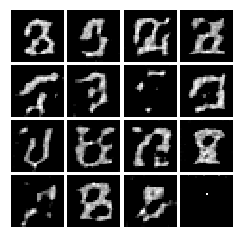


Iter: 4000, D: -3.301, G:-0.3173
Iter: 4100, D: -3.402, G:-0.3413
Iter: 4200, D: -3.02, G:-0.8415
Iter: 4300, D: -3.488, G:-0.3224
Iter: 4400, D: -3.028, G:-0.2527


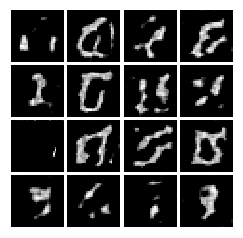


Iter: 4500, D: -3.267, G:-0.7152
Iter: 4600, D: -2.912, G:-0.4603
Iter: 4700, D: -3.093, G:-0.2869
Iter: 4800, D: -2.79, G:-0.2453
Iter: 4900, D: -3.155, G:-0.5473


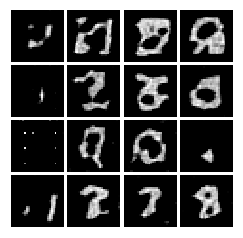


Iter: 5000, D: -2.891, G:-0.5538
Iter: 5100, D: -2.64, G:-0.4331
Iter: 5200, D: -2.521, G:-0.4919
Iter: 5300, D: -2.49, G:-0.6414
Iter: 5400, D: -2.687, G:-0.6536


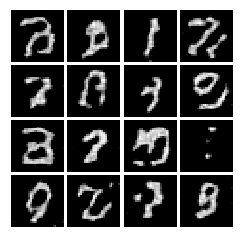


Iter: 5500, D: -2.825, G:-0.3475
Iter: 5600, D: -2.369, G:-0.6981
Iter: 5700, D: -2.699, G:-0.5745
Iter: 5800, D: -2.501, G:-0.3542
Iter: 5900, D: -2.38, G:-0.3713


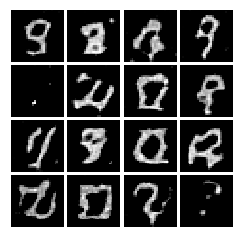


Iter: 6000, D: -2.26, G:-0.3823
Iter: 6100, D: -1.854, G:-0.441
Iter: 6200, D: -2.165, G:-0.6989
Iter: 6300, D: -2.239, G:-0.4023
Iter: 6400, D: -2.203, G:-0.6919


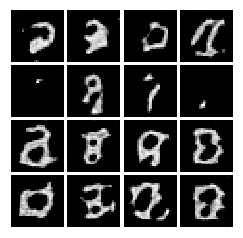


Iter: 6500, D: -2.396, G:-0.337
Iter: 6600, D: -1.938, G:-0.6904
Iter: 6700, D: -2.036, G:-0.5269
Iter: 6800, D: -2.099, G:-0.5447
Iter: 6900, D: -1.708, G:-1.005


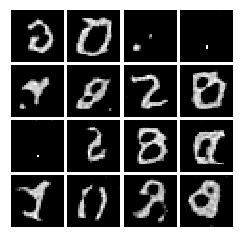


Iter: 7000, D: -1.999, G:-0.3814
Iter: 7100, D: -2.088, G:-0.2316
Iter: 7200, D: -1.827, G:-0.9984
Iter: 7300, D: -2.063, G:-0.3234
Iter: 7400, D: -2.235, G:-1.035


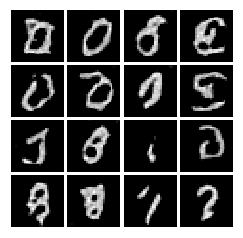


Iter: 7500, D: -1.982, G:-1.036
Iter: 7600, D: -2.127, G:-0.4227
Iter: 7700, D: -1.829, G:-0.5913
Iter: 7800, D: -1.873, G:-0.4291
Iter: 7900, D: -2.033, G:-0.4049


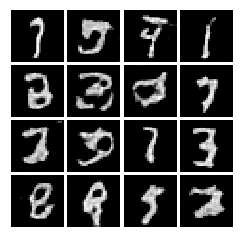


Iter: 8000, D: -1.766, G:-0.3043
Iter: 8100, D: -1.919, G:-0.265
Iter: 8200, D: -1.842, G:-0.1697
Iter: 8300, D: -1.555, G:-1.047
Iter: 8400, D: -1.888, G:-0.1742


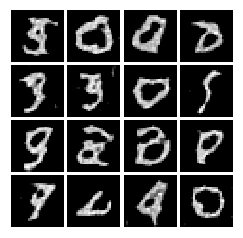


Iter: 8500, D: -1.739, G:-0.8456
Iter: 8600, D: -1.758, G:-0.2399
Iter: 8700, D: -1.683, G:-0.3006
Iter: 8800, D: -1.926, G:-0.4425
Iter: 8900, D: -1.904, G:-0.8529


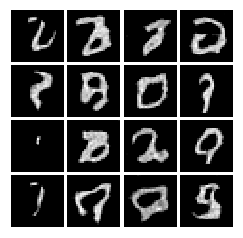


Iter: 9000, D: -1.595, G:-0.7913
Iter: 9100, D: -1.822, G:-0.7002
Iter: 9200, D: -1.781, G:-0.3431
Iter: 9300, D: -1.694, G:-0.5146
Iter: 9400, D: -1.91, G:-0.6798


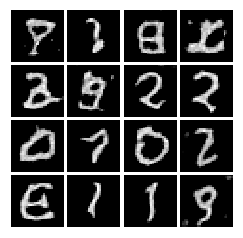


Iter: 9500, D: -1.542, G:-0.9716
Iter: 9600, D: -1.696, G:-0.64
Iter: 9700, D: -1.662, G:-0.1769
Iter: 9800, D: -1.727, G:-0.4718
Iter: 9900, D: -1.824, G:-0.6821


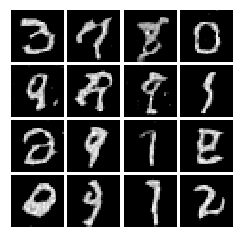


Iter: 10000, D: -1.771, G:-1.025
Iter: 10100, D: -1.487, G:-0.3945
Iter: 10200, D: -1.616, G:-0.2813
Iter: 10300, D: -1.469, G:-0.4702
Iter: 10400, D: -1.944, G:-0.266


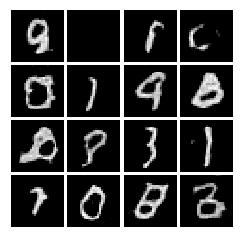


Iter: 10500, D: -1.705, G:-0.3709
Iter: 10600, D: -1.543, G:-1.045
Iter: 10700, D: -1.883, G:-0.3248
Iter: 10800, D: -1.846, G:-0.2072
Iter: 10900, D: -1.407, G:-0.4436


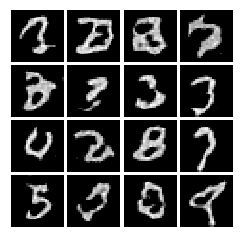


Iter: 11000, D: -1.834, G:-0.7975
Iter: 11100, D: -1.662, G:-0.7026
Iter: 11200, D: -1.455, G:-0.6436
Iter: 11300, D: -1.73, G:-0.9462
Iter: 11400, D: -1.77, G:-0.2255


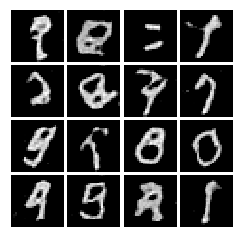


Iter: 11500, D: -1.538, G:-0.7851
Iter: 11600, D: -1.612, G:-0.07919
Iter: 11700, D: -1.731, G:-0.3704
Iter: 11800, D: -1.806, G:-0.73
Iter: 11900, D: -1.501, G:-0.8568


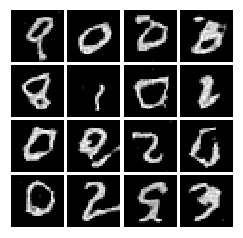


Iter: 12000, D: -1.604, G:-0.5703
Iter: 12100, D: -1.382, G:-0.5447
Iter: 12200, D: -1.131, G:-0.7558
Iter: 12300, D: -1.603, G:-1.545
Iter: 12400, D: -1.584, G:-0.8731


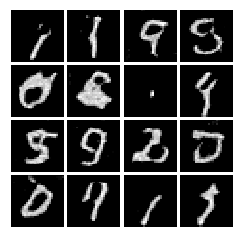


Iter: 12500, D: -1.386, G:-0.9157
Iter: 12600, D: -1.707, G:-1.033
Iter: 12700, D: -1.46, G:-0.8035
Iter: 12800, D: -1.468, G:-0.9768
Iter: 12900, D: -1.808, G:-0.1286


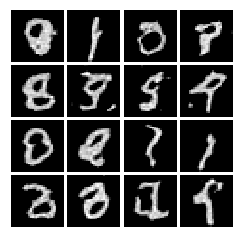


Iter: 13000, D: -1.77, G:-0.3281
Iter: 13100, D: -1.631, G:-0.191
Iter: 13200, D: -1.514, G:-0.1385
Iter: 13300, D: -1.442, G:-0.1025
Iter: 13400, D: -1.319, G:-0.6265


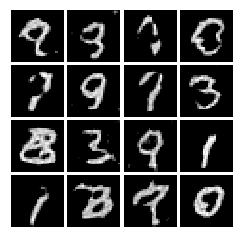


Iter: 13500, D: -1.944, G:-0.8175
Iter: 13600, D: -1.706, G:-0.857
Iter: 13700, D: -1.83, G:-0.5713
Iter: 13800, D: -1.493, G:-0.8429
Iter: 13900, D: -1.494, G:-0.9991


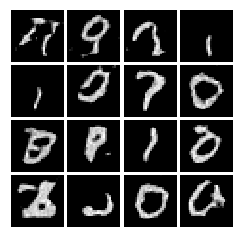


Iter: 14000, D: -1.915, G:-0.6377
Iter: 14100, D: -1.422, G:-1.414
Iter: 14200, D: -1.48, G:-0.6618
Iter: 14300, D: -1.441, G:-1.287
Iter: 14400, D: -1.654, G:-0.318


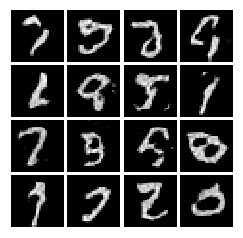


Iter: 14500, D: -1.677, G:-0.0564
Iter: 14600, D: -1.107, G:-1.078
Iter: 14700, D: -1.842, G:-0.691
Iter: 14800, D: -1.733, G:-0.2625
Iter: 14900, D: -1.597, G:-0.8782


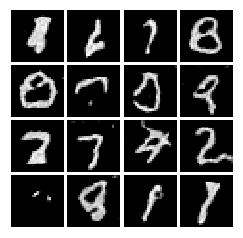


Iter: 15000, D: -1.614, G:-1.526
Iter: 15100, D: -1.443, G:-0.8476
Iter: 15200, D: -1.535, G:-0.3563
Iter: 15300, D: -1.324, G:-1.074
Iter: 15400, D: -1.618, G:-0.4906


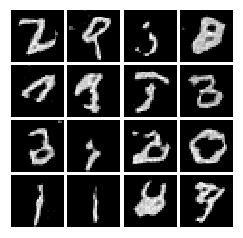


Iter: 15500, D: -1.125, G:-0.7955
Iter: 15600, D: -1.528, G:-0.2939
Iter: 15700, D: -1.603, G:-0.1763
Iter: 15800, D: -1.223, G:-1.757
Iter: 15900, D: -1.499, G:-1.241


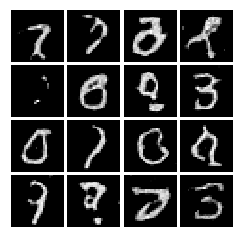


Iter: 16000, D: -1.595, G:-0.1763
Iter: 16100, D: -1.178, G:-1.395
Iter: 16200, D: -1.638, G:-1.168
Iter: 16300, D: -1.578, G:-0.2974
Iter: 16400, D: -1.351, G:-0.266


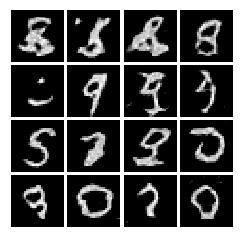


Iter: 16500, D: -1.523, G:-0.9248
Iter: 16600, D: -1.49, G:-0.1108
Iter: 16700, D: -1.407, G:-1.562
Iter: 16800, D: -1.183, G:-1.265
Iter: 16900, D: -1.38, G:-0.8764


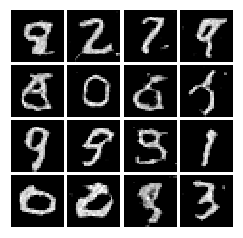


Iter: 17000, D: -1.673, G:-0.8916
Iter: 17100, D: -1.434, G:-0.814
Iter: 17200, D: -1.699, G:-1.087
Iter: 17300, D: -1.12, G:-1.064
Iter: 17400, D: -1.358, G:-0.8407


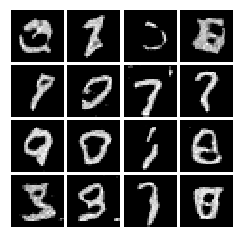


Iter: 17500, D: -1.721, G:-0.236
Iter: 17600, D: -1.555, G:-0.1771
Iter: 17700, D: -1.464, G:-0.886
Iter: 17800, D: -1.677, G:-0.1227
Iter: 17900, D: -1.442, G:-1.04


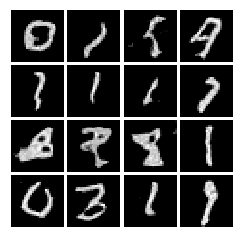


Iter: 18000, D: -1.412, G:-0.9283
Iter: 18100, D: -1.414, G:-0.5763
Iter: 18200, D: -1.451, G:-0.2936
Iter: 18300, D: -1.332, G:-0.4634
Iter: 18400, D: -1.267, G:-1.112


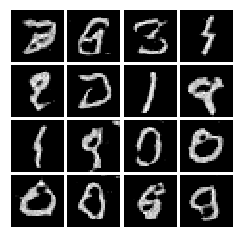


Iter: 18500, D: -1.611, G:-0.6592
Iter: 18600, D: -1.468, G:-0.9866
Iter: 18700, D: -1.423, G:-0.07963
Iter: 18800, D: -1.204, G:-0.7376
Iter: 18900, D: -1.791, G:-0.766


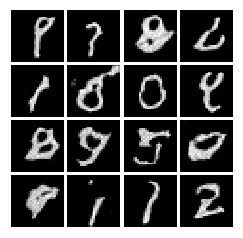


Iter: 19000, D: -1.562, G:-0.9962
Iter: 19100, D: -1.776, G:-0.02796
Iter: 19200, D: -1.61, G:-0.2342
Iter: 19300, D: -1.016, G:-0.893
Iter: 19400, D: -1.555, G:-0.09395


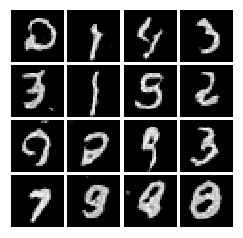


Iter: 19500, D: -1.717, G:-1.082
Iter: 19600, D: -1.634, G:-0.5535
Iter: 19700, D: -1.681, G:-0.2252
Iter: 19800, D: -1.515, G:-0.6948
Iter: 19900, D: -1.286, G:-0.4124


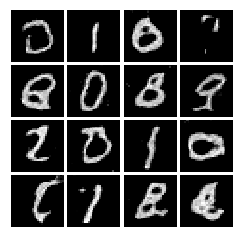


Iter: 20000, D: -1.56, G:-1.263
Iter: 20100, D: -1.305, G:-0.58
Iter: 20200, D: -1.598, G:-0.4773
Iter: 20300, D: -1.29, G:-0.9498
Iter: 20400, D: -1.472, G:-1.25


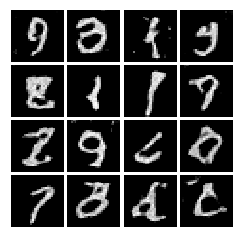


Iter: 20500, D: -1.585, G:-0.4686
Iter: 20600, D: -1.246, G:-0.6322
Iter: 20700, D: -1.579, G:-0.8764
Iter: 20800, D: -1.262, G:-1.274
Iter: 20900, D: -1.303, G:-1.081


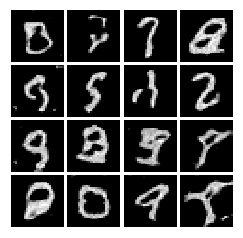


Iter: 21000, D: -1.542, G:-0.4428
Iter: 21100, D: -1.439, G:-0.5733
Iter: 21200, D: -1.389, G:-0.46
Iter: 21300, D: -1.403, G:-0.1152
Iter: 21400, D: -1.4, G:-0.2686


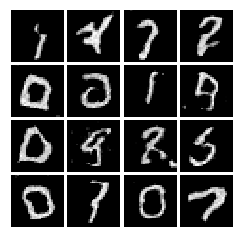


Iter: 21500, D: -1.384, G:-0.3298
Iter: 21600, D: -1.386, G:-0.3941
Iter: 21700, D: -1.341, G:-0.6108
Iter: 21800, D: -0.9807, G:-0.7035
Iter: 21900, D: -1.382, G:-0.51


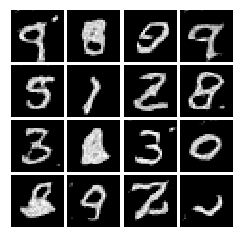


Iter: 22000, D: -1.302, G:-0.6989
Iter: 22100, D: -1.305, G:-0.4569
Iter: 22200, D: -1.338, G:-1.512
Iter: 22300, D: -1.309, G:-0.2049
Iter: 22400, D: -1.147, G:-0.841


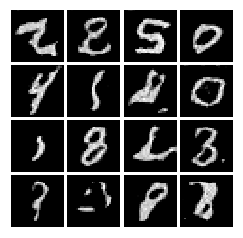


Iter: 22500, D: -1.798, G:-0.8147
Iter: 22600, D: -1.337, G:-1.066
Iter: 22700, D: -1.127, G:-0.4902
Iter: 22800, D: -1.323, G:-0.5326
Iter: 22900, D: -1.457, G:-0.3201


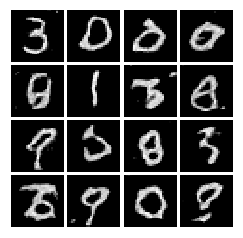


Iter: 23000, D: -1.425, G:-1.215
Iter: 23100, D: -1.346, G:-0.5902
Iter: 23200, D: -1.336, G:-0.7598
Iter: 23300, D: -1.231, G:-0.1188
Iter: 23400, D: -1.291, G:-0.9323


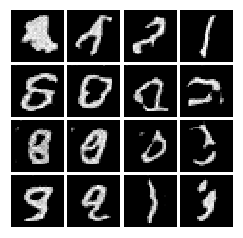


Iter: 23500, D: -1.356, G:-0.8926
Iter: 23600, D: -0.9626, G:-1.192
Iter: 23700, D: -1.127, G:-0.6936
Iter: 23800, D: -1.272, G:-0.7125
Iter: 23900, D: -1.424, G:-0.3961


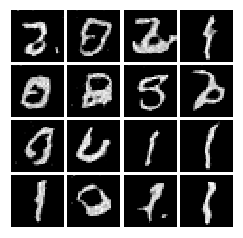


Iter: 24000, D: -1.514, G:-0.6415
Iter: 24100, D: -1.186, G:-0.1094
Iter: 24200, D: -1.375, G:-0.4164
Iter: 24300, D: -1.424, G:-0.2043
Iter: 24400, D: -1.321, G:-0.6224


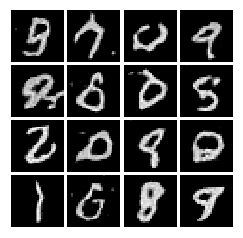


Iter: 24500, D: -1.566, G:-0.4433
Iter: 24600, D: -1.394, G:-0.9322
Iter: 24700, D: -1.023, G:-0.3642
Iter: 24800, D: -1.129, G:-1.177
Iter: 24900, D: -1.326, G:-0.1947


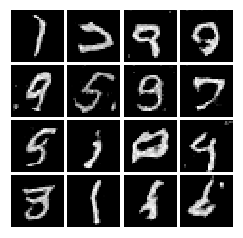


Iter: 25000, D: -1.054, G:-1.026
Iter: 25100, D: -1.411, G:-0.5691
Iter: 25200, D: -1.362, G:-0.5107
Iter: 25300, D: -1.176, G:-1.683
Iter: 25400, D: -1.361, G:-0.9345


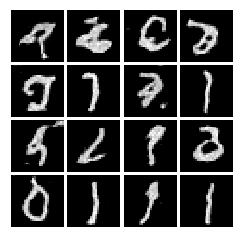


Iter: 25500, D: -1.508, G:-1.357
Iter: 25600, D: -1.153, G:-0.6126
Iter: 25700, D: -1.182, G:-0.6492
Iter: 25800, D: -1.021, G:-0.3385
Iter: 25900, D: -1.24, G:-0.6461


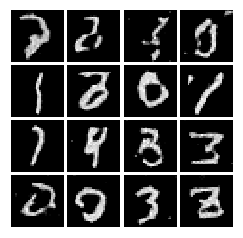


Iter: 26000, D: -1.365, G:-0.6106
Iter: 26100, D: -0.8492, G:-0.9934
Iter: 26200, D: -0.8859, G:-0.5449
Iter: 26300, D: -1.132, G:-0.1472
Iter: 26400, D: -1.389, G:-1.789


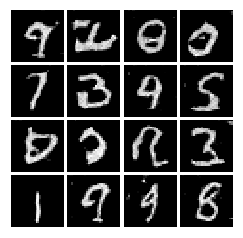


Iter: 26500, D: -1.315, G:-0.2305
Iter: 26600, D: -1.133, G:-0.6293
Iter: 26700, D: -1.13, G:-0.7305
Iter: 26800, D: -1.29, G:-0.2995
Iter: 26900, D: -1.294, G:-1.163


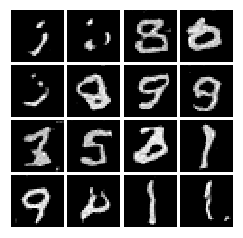


Iter: 27000, D: -1.359, G:-1.018
Iter: 27100, D: -0.9763, G:-0.504
Iter: 27200, D: -1.099, G:-0.4352
Iter: 27300, D: -1.035, G:-0.6265
Iter: 27400, D: -0.9809, G:-1.068


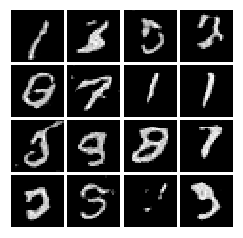


Iter: 27500, D: -1.249, G:-0.5348
Iter: 27600, D: -1.204, G:-1.209
Iter: 27700, D: -1.236, G:-0.7183
Iter: 27800, D: -1.111, G:-0.3984
Iter: 27900, D: -1.237, G:-1.226


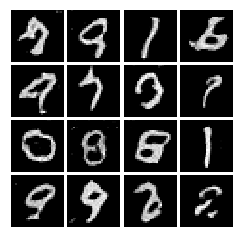


Iter: 28000, D: -1.552, G:-1.469
Iter: 28100, D: -1.088, G:-1.16
Iter: 28200, D: -0.8363, G:-1.416
Iter: 28300, D: -1.285, G:-0.9202
Iter: 28400, D: -0.9181, G:-0.6139


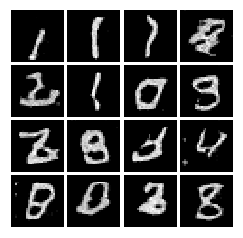


Iter: 28500, D: -1.703, G:-0.5108
Iter: 28600, D: -1.008, G:-0.5305
Iter: 28700, D: -1.241, G:-0.4378
Iter: 28800, D: -1.222, G:-0.967
Iter: 28900, D: -1.249, G:-0.8251


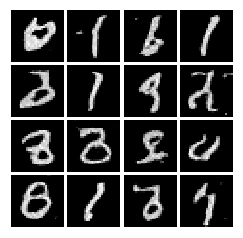


Iter: 29000, D: -1.565, G:-0.243
Iter: 29100, D: -1.099, G:-0.8592
Iter: 29200, D: -1.184, G:-0.1396
Iter: 29300, D: -0.9067, G:-0.4195
Iter: 29400, D: -1.164, G:-1.082


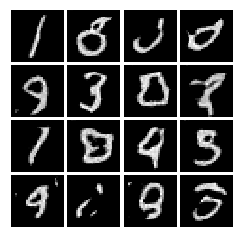


Iter: 29500, D: -1.161, G:-0.1944
Iter: 29600, D: -0.8429, G:-0.4497
Iter: 29700, D: -1.297, G:-0.5601
Iter: 29800, D: -1.163, G:-0.3018
Iter: 29900, D: -0.6319, G:-0.7053


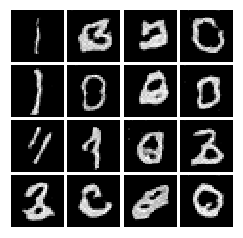


Iter: 30000, D: -1.434, G:-0.3362
Iter: 30100, D: -0.9563, G:-0.9947
Iter: 30200, D: -1.004, G:-0.4114
Iter: 30300, D: -1.303, G:-1.557
Iter: 30400, D: -0.7833, G:-1.614


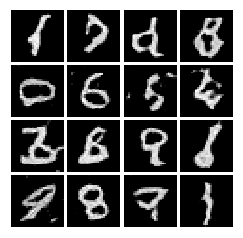


Iter: 30500, D: -1.103, G:-0.4924
Iter: 30600, D: -1.065, G:-0.696
Iter: 30700, D: -1.151, G:-0.2941
Iter: 30800, D: -1.18, G:-1.279
Iter: 30900, D: -0.8531, G:-1.495


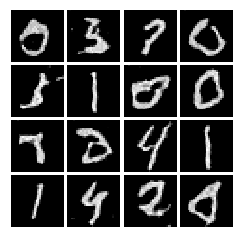


Iter: 31000, D: -1.092, G:-1.106
Iter: 31100, D: -1.039, G:-1.076
Iter: 31200, D: -1.31, G:-0.5034
Iter: 31300, D: -0.9494, G:-1.807
Iter: 31400, D: -0.9152, G:-1.061


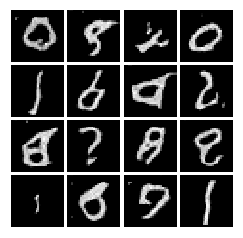


Iter: 31500, D: -1.283, G:-0.3452
Iter: 31600, D: -1.068, G:-0.8966
Iter: 31700, D: -1.126, G:-0.4838
Iter: 31800, D: -1.088, G:-0.5132
Iter: 31900, D: -1.065, G:-0.8399


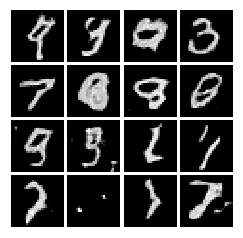


Iter: 32000, D: -1.131, G:-0.3378
Iter: 32100, D: -1.12, G:-0.6173
Iter: 32200, D: -1.145, G:-0.1778
Iter: 32300, D: -1.167, G:-0.5925
Iter: 32400, D: -1.09, G:-0.5801


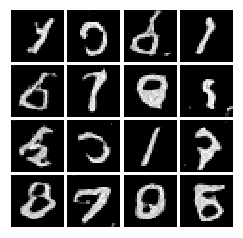


Iter: 32500, D: -1.396, G:-0.491
Iter: 32600, D: -0.9352, G:-0.7284
Iter: 32700, D: -1.029, G:-0.8057
Iter: 32800, D: -1.044, G:-0.6719
Iter: 32900, D: -1.203, G:-0.8967


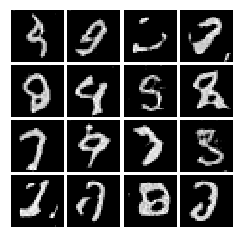


Iter: 33000, D: -1.079, G:-0.7995
Iter: 33100, D: -1.177, G:-0.8372
Iter: 33200, D: -1.069, G:-0.8304
Iter: 33300, D: -0.7446, G:-0.898
Iter: 33400, D: -1.194, G:-0.6075


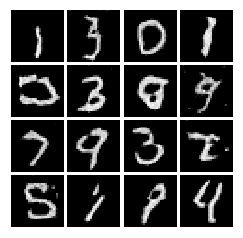


Iter: 33500, D: -1.186, G:-1.638
Iter: 33600, D: -0.9605, G:-0.5065
Iter: 33700, D: -1.11, G:-1.732
Iter: 33800, D: -0.9204, G:-0.8451
Iter: 33900, D: -0.8805, G:-1.514


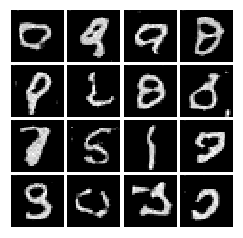


Iter: 34000, D: -1.462, G:-0.1588
Iter: 34100, D: -1.254, G:-0.4114
Iter: 34200, D: -0.9287, G:-1.039
Iter: 34300, D: -0.7995, G:-1.852
Iter: 34400, D: -0.9603, G:-0.5455


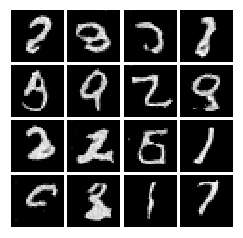


Iter: 34500, D: -0.9997, G:-0.2044
Iter: 34600, D: -1.109, G:-0.2488
Iter: 34700, D: -1.183, G:-0.4074
Iter: 34800, D: -0.9898, G:-0.6051
Iter: 34900, D: -0.8135, G:-0.9493


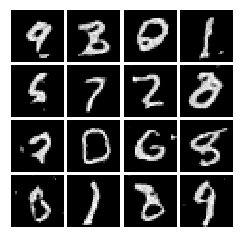


Iter: 35000, D: -1.085, G:-1.385
Iter: 35100, D: -1.141, G:-0.2094
Iter: 35200, D: -0.8383, G:-0.861
Iter: 35300, D: -1.149, G:-0.3333
Iter: 35400, D: -0.791, G:-0.7241


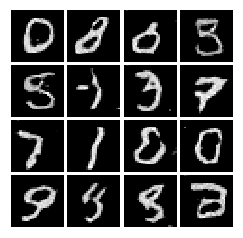


Iter: 35500, D: -0.9827, G:-0.8854
Iter: 35600, D: -0.8921, G:-1.055
Iter: 35700, D: -0.8917, G:-0.2615
Iter: 35800, D: -1.304, G:-0.831
Iter: 35900, D: -1.079, G:-0.7854


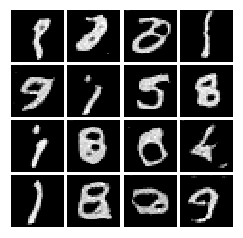


Iter: 36000, D: -1.09, G:-0.45
Iter: 36100, D: -1.015, G:-0.7263
Iter: 36200, D: -0.9284, G:-0.6275
Iter: 36300, D: -0.7732, G:-0.2734
Iter: 36400, D: -1.115, G:-0.04727


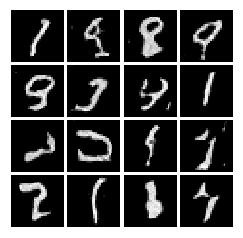


Iter: 36500, D: -0.8717, G:-1.351
Iter: 36600, D: -1.108, G:-0.4825
Iter: 36700, D: -0.9712, G:-0.7993
Iter: 36800, D: -0.8973, G:-0.994
Iter: 36900, D: -1.007, G:-1.125


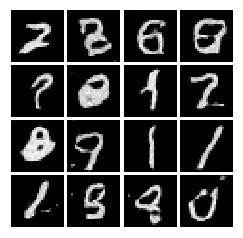


Iter: 37000, D: -1.078, G:-0.3313
Iter: 37100, D: -0.9386, G:-1.319
Iter: 37200, D: -0.8774, G:-0.3428
Iter: 37300, D: -1.094, G:-0.5418
Iter: 37400, D: -0.9136, G:-0.7717


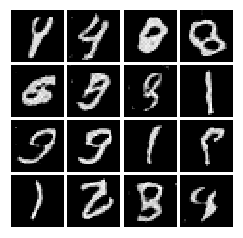


Iter: 37500, D: -1.18, G:-1.009
Iter: 37600, D: -0.8885, G:-0.4051
Iter: 37700, D: -0.899, G:-0.4331
Iter: 37800, D: -1.002, G:-1.747
Iter: 37900, D: -0.9313, G:-0.1522


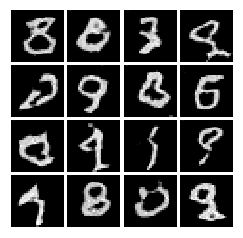


Iter: 38000, D: -1.059, G:-0.5113
Iter: 38100, D: -0.6967, G:-0.7884
Iter: 38200, D: -0.9239, G:-1.46
Iter: 38300, D: -0.9855, G:-0.5513
Iter: 38400, D: -0.9709, G:-0.8816


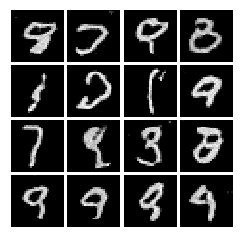


Iter: 38500, D: -0.585, G:-1.787
Iter: 38600, D: -0.9714, G:-1.148
Iter: 38700, D: -0.9633, G:-0.5001
Iter: 38800, D: -0.911, G:-0.1737
Iter: 38900, D: -1.001, G:-0.4799


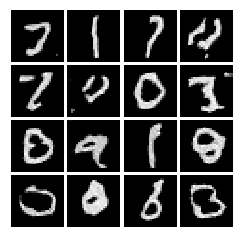


Iter: 39000, D: -1.004, G:-0.643
Iter: 39100, D: -1.108, G:-0.6317
Iter: 39200, D: -1.049, G:-0.1805
Iter: 39300, D: -1.075, G:-0.662
Iter: 39400, D: -0.869, G:-0.4632


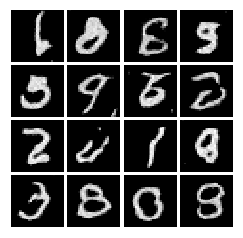


Iter: 39500, D: -1.012, G:-1.423
Iter: 39600, D: -0.7767, G:-0.7587
Iter: 39700, D: -1.048, G:-1.582
Iter: 39800, D: -0.8692, G:-0.1492
Iter: 39900, D: -0.8742, G:-0.4569


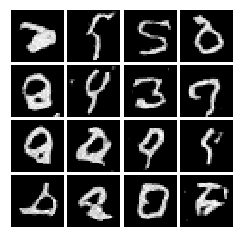


Iter: 40000, D: -0.9411, G:-0.1719
Iter: 40100, D: -0.8211, G:-1.751
Iter: 40200, D: -0.9032, G:-0.543
Iter: 40300, D: -0.8952, G:-0.2755
Iter: 40400, D: -0.8118, G:-0.7761


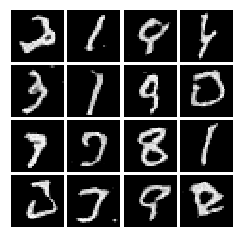


Iter: 40500, D: -0.9359, G:-0.6122
Iter: 40600, D: -0.8168, G:-1.209
Iter: 40700, D: -1.004, G:-0.995
Iter: 40800, D: -0.9488, G:-0.2201
Iter: 40900, D: -0.8929, G:-0.5423


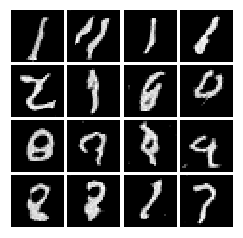


Iter: 41000, D: -0.997, G:-0.5241
Iter: 41100, D: -0.7853, G:-1.254
Iter: 41200, D: -1.012, G:-0.4519
Iter: 41300, D: -0.7919, G:-0.8807
Iter: 41400, D: -0.7849, G:-0.1955


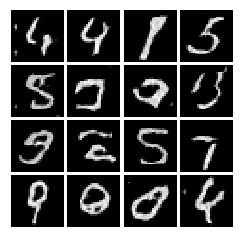


Iter: 41500, D: -1.255, G:-0.9116
Iter: 41600, D: -1.009, G:-0.1061
Iter: 41700, D: -0.8531, G:-0.2319
Iter: 41800, D: -1.065, G:-0.3722
Iter: 41900, D: -0.6455, G:-1.173


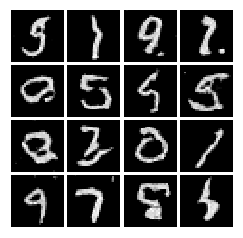


Iter: 42000, D: -1.053, G:-0.4384
Iter: 42100, D: -0.9447, G:-0.8829
Iter: 42200, D: -0.9468, G:-0.6691
Iter: 42300, D: -0.7324, G:-1.519
Iter: 42400, D: -0.9746, G:-0.357


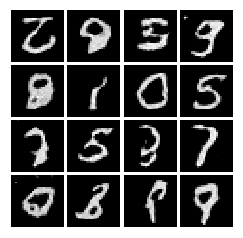


Iter: 42500, D: -0.8366, G:-0.7551
Iter: 42600, D: -1.001, G:-0.4877
Iter: 42700, D: -0.684, G:-1.471
Iter: 42800, D: -0.9113, G:-0.8464
Iter: 42900, D: -0.7351, G:-0.4278
Final images


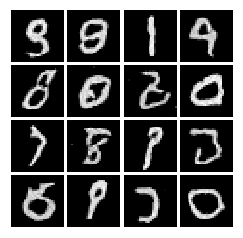

In [26]:
with get_session() as sess:
    sess.run(tf.global_variables_initializer())
    run_a_gan(sess,G_train_step,G_loss,D_train_step,D_loss)